# Importing libraries and setting the logger

In [65]:
import pandas as pd
import numpy as np
import urllib3
from bs4 import BeautifulSoup
import logging
import re
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load Logging definition
logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger('jupyter-info')


INFO:matplotlib.font_manager:Could not open font file /Library/Fonts/NISC18030.ttf


## Loading files

In [23]:
"""Read a Xlsx"""
medications_file = 'data/myfile.xlsx'
df_medications = pd.read_excel(medications_file)
df_medications.head()

,Unnamed: 0,sku,title,description,molecule
0,0,7501125109706,Neomixen Neomicina 10 Tabletas Caja,Neomicina 250 MG,neomicina
1,1,7501125155697,Montipedia 30 Comprimidos Caja,Montelukast 10 MG,montelukast
2,2,7501125113123,ONEMER INYECCIÓN 3 U AMPOLLETAS,ketorolaco trometamina 30 mg,ketorolaco
3,3,7501125135460,Onemer Sublingual 6 Tabletas Caja,Ketorolaco trometamina 30 MG,ketorolaco
4,4,7501125109904,Nimepis 10 Tabletas Caja,Nimesulida 100 MG,nimesulida


In [49]:
""" Read a json Dump (mongoDB)"""
prod_db_file = 'data/new_dump.json'
df_dump = pd.read_json ('data/new_dump.json', lines = True)
# remove the column _id (mongo id)
df_dump = df_dump.drop(columns="_id")
df_dump.head()

,description,molecule,sku,title
0,Neomicina 250 MG,SULFATO DE NEOMICINA,7501125109706,Neomixen Neomicina 10 Tabletas Caja
1,Montelukast 10 MG,,7501125155697,Montipedia 30 Comprimidos Caja
2,ketorolaco trometamina 30 mg,,7501125113123,ONEMER INYECCIÓN 3 U AMPOLLETAS
3,Ketorolaco trometamina 30 MG,,7501125135460,Onemer Sublingual 6 Tabletas Caja
4,Nimesulida 100 MG,,7501125109904,Nimepis 10 Tabletas Caja


## Functions definition

In [78]:

def get_html_page(page_url):
    """ Get the whole page source code"""
    try:
        http = urllib3.PoolManager()
        response = http.request('GET', page_url)
        soup = BeautifulSoup(response.data, 'html.parser')
        response.release_conn()
        return soup
    except Exception as e:
        logger.error(F"[ERROR] downloading the requested page source code: {e}")
        return None


def get_soup_obj_by_dom_tag(soup, object_dom, tag_value, object_tag="class"):
    """ Search for all the objects in the current soup object with this specific HTML dom and tag value"""
    object_array = soup.find_all(object_dom, attrs={object_tag: tag_value})
    return object_array


def get_soup_obj_by_dom(soup, object_dom):
    """ Search for all the objects in the current soup object with this specific HTML dom and tag value"""
    object_array = soup.find_all(object_dom)
    return object_array


def get_soup_tables_on_single_table(soup, table_tag_value, table_tag="class", columns_to_keep=[]):
    """ Search for all the objects in the current soup object with this specific HTML dom and tag value"""
    new_table_array = []
    tables_array = soup.find_all("table", attrs={table_tag: table_tag_value})
    for current_table in tables_array:
        table_body = current_table.find('tbody')
        table_rows = table_body.find_all('tr')
        table_rows.pop(0)  # Remove the column names
        table_rows.pop(-1)  # Remove the last column names
        for row in table_rows:
            if not columns_to_keep:
                new_table_array.append(row)
            else:
                new_row = []
                table_fields = row.find_all('td')
                for index in columns_to_keep:
                    if table_fields[index]:
                        new_row.append(table_fields[index])
                new_table_array.append(new_row)

    return new_table_array


def get_html_obj_by_dom_tag(page_url, object_dom, tag_value, object_tag="class"):
    """ Search for all the objects in the current url with this specific HTML dom and class"""
    http = urllib3.PoolManager()
    response = http.request('GET', page_url)
    soup = BeautifulSoup(response.data, 'html.parser')
    object_array = soup.find_all(object_dom, attrs={object_tag: tag_value})
    response.release_conn()
    return object_array


def get_text_from_object(object_array):
    """ Receives a soup4 object array and returns a string array with the text of each object"""
    return [current_tag.text.strip() for current_tag in object_array]


def get_tag_from_object(object_array, tag):
    """ Receives a soup4 object array and returns a string array with the text of the tag of each object"""
    return [current_tag.get(tag) for current_tag in object_array]

def download_file_by_url(url, file_name):
    """Download the file at a url location and store it locally"""
    try:
        http = urllib3.PoolManager()
        response_file = http.request('GET', url, preload_content=False)
        logger.info(F"Download status: {response_file.status}, {url}")

        with open(F"data/{file_name}", "wb") as out:
            while True:
                data = response_file.read(1024)
                if not data:
                    break
                out.write(data)

        return True
    except Exception as e:
        logger.error(F"[ERROR] downloading the file: {e}")
        return False




## Using the functions

/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
INFO:jupyter-info:Download status: 200, https://www.farmalisto.com.mx/35126-medium_default/neomixen-25omg-caja-con-10-tabletas-antibiotico-7501125109706.jpg


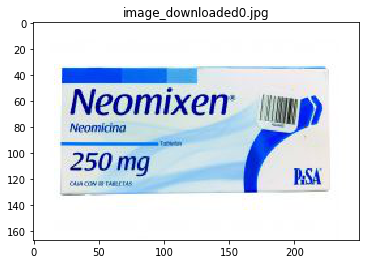

/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
INFO:jupyter-info:Download status: 200, https://www.farmalisto.com.mx/35125-medium_default/neomixen-25omg-caja-con-10-tabletas-antibiotico-7501125109706.jpg


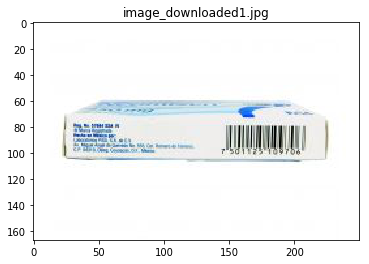

/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
INFO:jupyter-info:Download status: 200, https://www.farmalisto.com.mx/52364-medium_default/nebapol-unguento-caja-con-un-tubo-con-30g-7501089804358.jpg


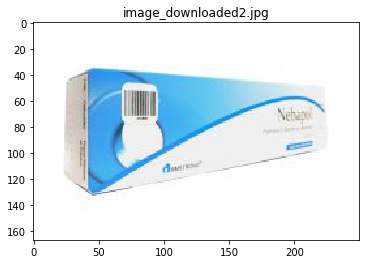

/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
INFO:jupyter-info:Download status: 200, https://www.farmalisto.com.mx/52362-medium_default/nebapol-unguento-caja-con-un-tubo-con-30g-7501089804358.jpg


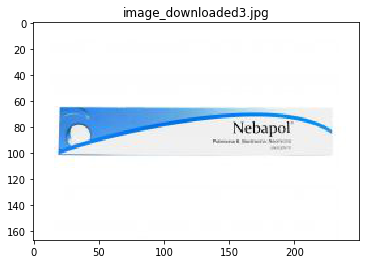

In [82]:
page_url = F"https://www.the_site_im_gonna_scrape.com.mx/resultados?s={df_dump.iloc[0].description}"
#Get the whole page on a soup object
soup = get_html_page(page_url)
if soup: # check if we could get the source code
    #search for all the images with classes: "smooth05 cover-image"
    tag_object_list = get_soup_obj_by_dom_tag(soup, "img", "smooth05 cover-image" , object_tag="class")
    #get the src of each image
    images_url_list = get_tag_from_object(tag_object_list, "src")
    #Download each image from the url
    for index, tag_href in enumerate(images_url_list):
        image_name = F"image_downloaded{index}.jpg"
        download_file_by_url(tag_href, image_name)
        image = mpimg.imread(F"data/{image_name}")
        plt.title(image_name)
        plt.imshow(image)
        plt.show()